In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import time
from module.lib.layers import *
import pandas as pd
import cv2
import glob
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"]=18

In [1]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

NameError: name 'tf' is not defined

In [3]:
y_test.shape

(10000,)

In [3]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [9]:
shape = (100, 100)
inputs = tf.keras.Input((100, 100))
#x = ImageResizing(shape)(inputs)
#x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = IntensityToElectricField(shape, ini_theta=-np.pi/6.0)(inputs)
#x = MO(shape, limitation=None, theta=1.0, eta=0.2)(x)
#x = AngularSpectrum(shape, wavelength=532e-9, z=0.5e-3, d=1.0e-6, method='expand')(x)
x = FaradayRotationByStokes(shape)(x)
# x = D2NNMNISTFilter(shape)(x)
#x = Polarizer(shape, phi=np.pi/4)(x)
#x = ElectricFieldToIntensity(shape)(x)
# x = D2NNMNISTDetector(10)(x)
# x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)

2022-07-07 09:58:49.973138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_87205/370465583.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


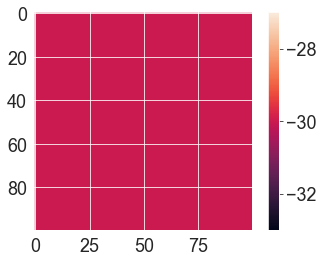

In [10]:
one = np.ones((2, *shape))
pred = model.predict(one)
plt.imshow(pred[0,:,:]*180/np.pi)
plt.colorbar()

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3059/4271244717.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


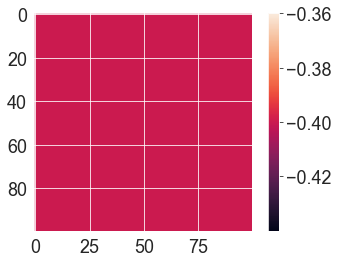

In [5]:
XX, YY = np.mgrid[:100, :100]*0.1
R = np.sqrt(XX**2 + YY**2)
W = model.layers[4].get_weights()
W[0] = R * 0 -0.4
model.layers[4].set_weights(W)
ones = np.ones([1, 28, 28])
pred = model.predict(ones)
rcp = pred[0,0,:,:,:]
lcp = pred[0,1,:,:,:]
Er = np.abs(rcp[0,:,:])
El = np.abs(lcp[0,:,:])
eta = (Er-El)/(Er+El)
plt.imshow(eta)
plt.colorbar()

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3136/619310815.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


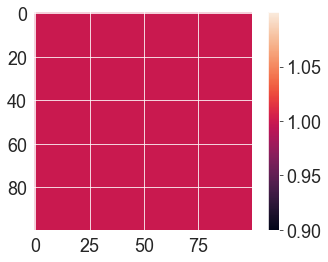

In [14]:
XX, YY = np.mgrid[:100, :100]*0.1
R = np.sqrt((XX-np.mean(XX))**2 + (YY-np.mean(YY))**2)
W = model.layers[2].get_weights()
W[0] = R * 0 + np.pi/4
model.layers[2].set_weights(W)
ones = np.ones([1, 100, 100])
pred = model.predict(ones)
plt.imshow(pred[0,:,:])
plt.colorbar()

2022-06-22 16:15:13.078363: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-22 16:15:13.130587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


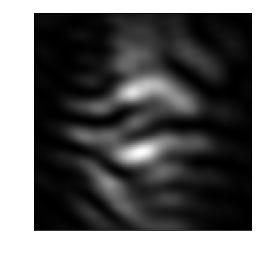

In [6]:
pred = model.predict(x_train[0:1,:,:])
plt.imshow(pred[0,:,:], cmap='gray')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.grid(False)
# plt.savefig("images/5.svg")

6.444416


2022-06-25 18:39:22.388417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_84535/3329558001.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


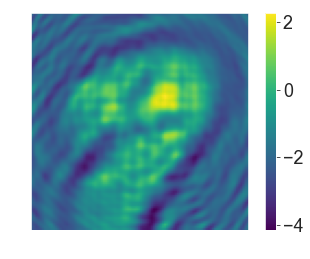

In [68]:
weights = model.layers[4].get_weights()
phase = ((np.loadtxt("data/phase/100px/train_7.csv")-0.5) * 2.0) * 2.1 * np.pi / 180
tx = np.linspace(-np.pi, np.pi, 100)
ty = np.linspace(-np.pi, np.pi, 100)
XX, YY = np.meshgrid(tx, ty)
W = np.sqrt(XX**2 + YY**2)
weights[0] = phase
model.layers[4].set_weights(weights)
image = np.ones((2, 28, 28))
pred = model.predict(image) * 180 / np.pi
plt.imshow(pred[0,:,:], cmap="viridis")
plt.colorbar()
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.grid(False)
print(pred.max() - pred.min())

In [53]:
model.layers[2]

In [ ]:
pred = model.predict(x_train[0:1,:,:])
label = np.arange(0, 10, 1)
plt.bar(label, pred[0,:])
plt.grid(False)
plt.xticks(label, [str(i) for i in label])
plt.xlabel("Label")
plt.ylabel("Probability")

In [ ]:
model = tf.keras.models.load_model("test")
model.summary()

In [ ]:
def check_zero_range(x, eps):
    return -eps < x < eps

e = np.arange(-5, 5, 1.0)
x = 10.0**e
XX, YY = np.meshgrid(x, x)

a = tf.constant(XX, dtype=tf.float16)
b = tf.constant(YY, dtype=tf.float16)
arg = 2.0 * tf.atan((tf.sqrt(a**2 + b**2) - a)/b)

print(arg[np.isnan((arg.numpy()))].shape)
plt.imshow(np.isnan(arg.numpy()))


In [ ]:
columns = ["epoch", "pi/100", "pi/10", "pi/5", "pi/3", "pi/2", "pi"]
path = "trained_model/20220415_*/*.csv"
files = glob.glob(path)
files.sort()
data = []
a = pd.read_csv(files[0])
for i, file in enumerate(files):
    df = pd.read_csv(file)
    if i == 0:
        data.append(df.index.values + 1)
    data.append(df["accuracy"].values)
data = pd.DataFrame(np.array(data).T, columns=columns)
data.plot(x="epoch")

In [ ]:
x = np.arange(-50.0, 0.0).reshape((5, 10))
x_min = tf.reduce_min(x, axis=-1, keepdims=True)
tf.nn.softmax(x - x_min, axis=-1)

あいうえお

In [ ]:
def check_zero_range(x, eps):
    return -eps < x < eps

e = np.arange(-5, 5, 1.0)
x = 10.0**e
XX, YY = np.meshgrid(x, x)

a = tf.constant(XX, dtype=tf.float16)
b = tf.constant(YY, dtype=tf.float16)
arg = 2.0 * tf.atan((tf.sqrt(a**2 + b**2) - a)/b)

print(arg[np.isnan((arg.numpy()))].shape)
plt.imshow(np.isnan(arg.numpy()))


In [ ]:
columns = ["epoch", "pi/100", "pi/10", "pi/5", "pi/3", "pi/2", "pi"]
path = "trained_model/20220415_*/*.csv"
files = glob.glob(path)
files.sort()
data = []
a = pd.read_csv(files[0])
for i, file in enumerate(files):
    df = pd.read_csv(file)
    if i == 0:
        data.append(df.index.values + 1)
    data.append(df["accuracy"].values)
data = pd.DataFrame(np.array(data).T, columns=columns)
data.plot(x="epoch")

In [ ]:
x = np.arange(-50.0, 0.0).reshape((5, 10))
x_min = tf.reduce_min(x, axis=-1, keepdims=True)
tf.nn.softmax(x - x_min, axis=-1)

In [13]:
path = "trained_model/20220424_*"
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
for file in files[6:]:
    model = tf.keras.models.load_model(file)
    phi = model.layers[-4].get_weights()[0] * 180/np.pi
    print(model.layers[4].limitation_num.numpy() * 180/np.pi,(phi + 180)%180)

1.8000000927782456 80.83268652502716
18.000000500895634 104.96656755204224
36.00000100179127 128.67429418003448
60.000001669652114 146.23434170592208
90.00000250447816 25.833646912820797
180.00000500895632 18.085579356101306


In [17]:
plt.imsave('images/5.png', x_train[0,:,:], dpi=300, cmap="")

In [5]:
path = 'trained_model/20220424_8'
model = tf.keras.models.load_model(path)

plt.rcParams["font.size"] = 20
output_class = CxD2NNIntensity
pattern = r'angular_spectrum'
outputs = [model.layers[2].output]
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        outputs.append(output_class((100, 100))(layer.output))
# outputs.pop(-2)
outputs.append(D2NNMNISTFilter((100, 100))(model.layers[-3].output))
outputs.append(model.layers[-2].output)
hidden_layer_model = tf.keras.Model(model.inputs, outputs=outputs)
input_images = np.array([x_test[7815,:,:], x_test[7977,:,:]])
pred1 = hidden_layer_model.predict(input_images)

path = 'trained_model/20220425_5'
model = tf.keras.models.load_model(path)

output_class = CxD2NNFaradayRotation
pattern = r'angular_spectrum'
outputs = [model.layers[2].output]
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        outputs.append(output_class((100, 100))(layer.output))
phi = model.layers[4].limitation_num.numpy()
outputs.append(D2NNMNISTFilter((100, 100))(model.layers[-3].output))
outputs.append(model.layers[-2].output)
hidden_layer_model = tf.keras.Model(model.inputs, outputs=outputs)
input_images = np.array([x_test[6810,:,:], x_test[285,:,:]])
pred2 = hidden_layer_model.predict(input_images)

2022-05-31 10:01:25.893808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 10:01:27.155898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
pred = []
for i in range(len(pred1)):
    pred.append(np.concatenate([pred1[i], pred2[i]], axis=0))

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_58026/2034503474.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(axes[j, 6].images[0], cax=cbar_ax)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_58026/2034503474.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(axes[j, 0].images[0], cax=cbar_ax)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_58026/2034503474.py:64: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(axes[j, i].images[0], cax=cbar_ax, ticks=[-i*np.pi/100, 0, i*np.pi/10

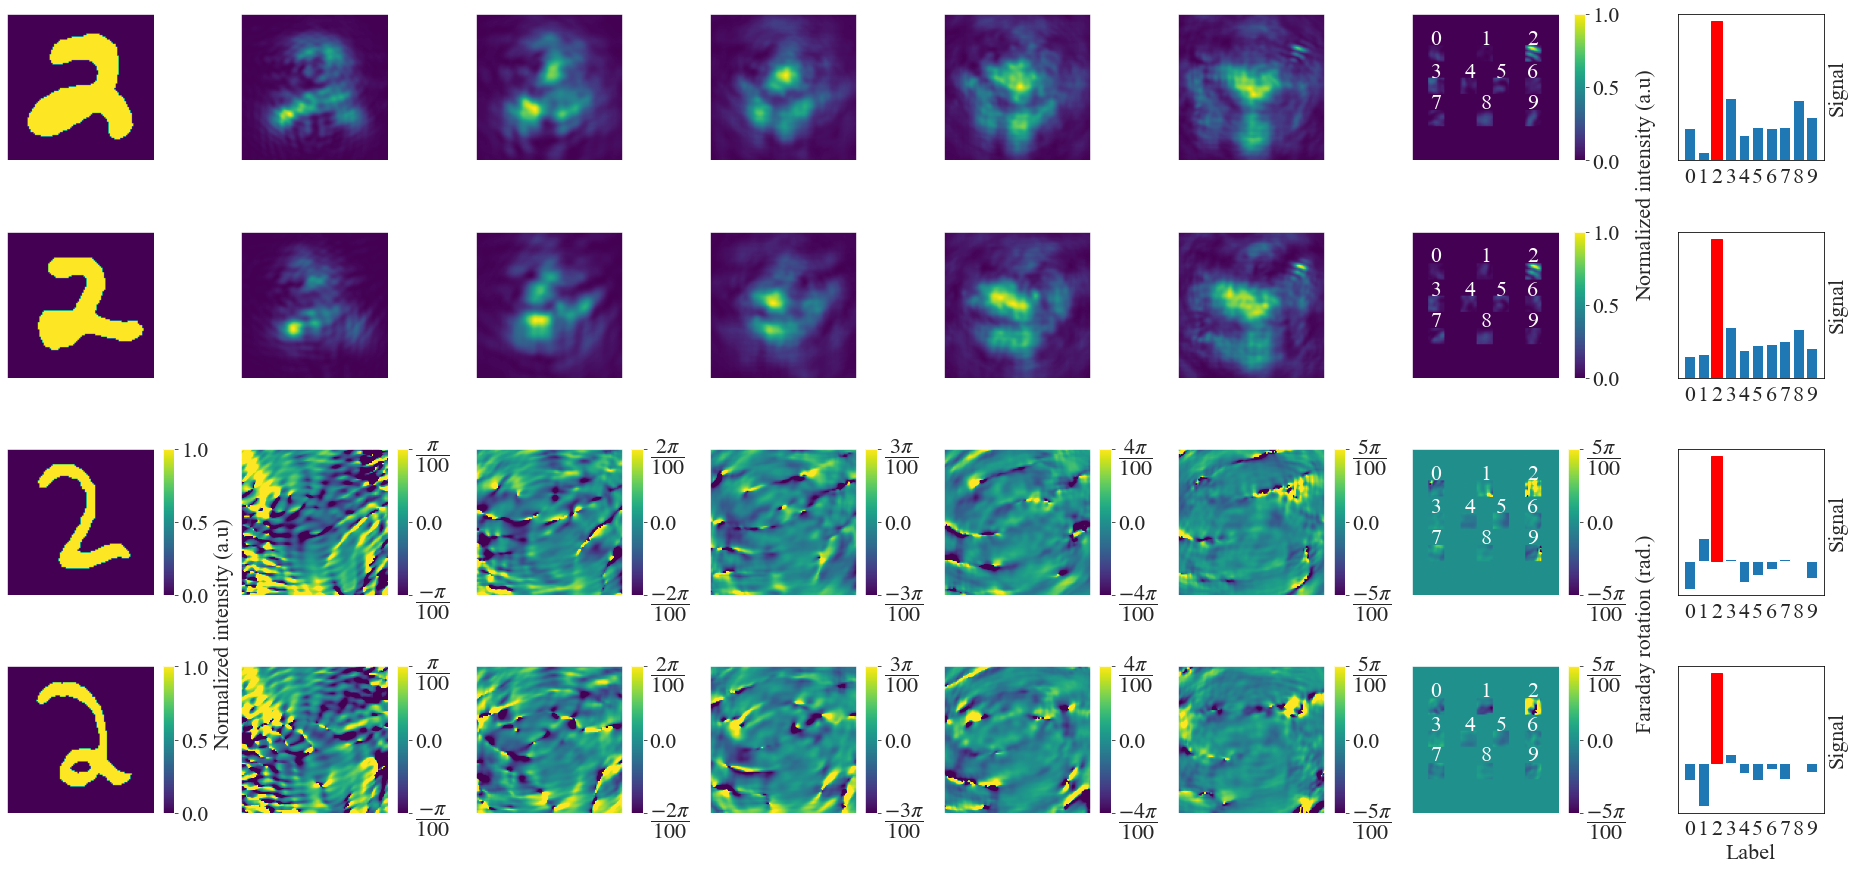

In [7]:
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"]=22
fig, axes = plt.subplots(4, len(pred1), figsize=(4 * len(pred1), 4 * 4))
fig.subplots_adjust(wspace=0.6, hspace=0)
for _ax in axes:
    for ax in _ax:
        ax.grid(False)
        ax.set_xticks([],color="none")
        ax.set_yticks([],color="none")

for j in range(2):
    for i in range(7):
        norm_image = pred[i][j,:,:] / np.max(pred[i][j,:,:])
        axes[j, i].imshow(norm_image, cmap='viridis', vmin=0., vmax=1.)

    axes[j, 6].tick_params(labelright=True, labelleft=False)
    axpos = axes[j,6].get_position()
    cbar_ax = fig.add_axes([0.805, axpos.y0, 0.005, axpos.height])
    cbar = fig.colorbar(axes[j, 6].images[0], cax=cbar_ax)

    axes[j, 6].text(12,20, "0", color="white")
    axes[j, 6].text(46,20, "1", color="white")
    axes[j, 6].text(78,20, "2", color="white")
    axes[j, 6].text(12,43, "3", color="white")
    axes[j, 6].text(35,43, "4", color="white")
    axes[j, 6].text(56.5,43, "5", color="white")
    axes[j, 6].text(78,43, "6", color="white")
    axes[j, 6].text(12,64, "7", color="white")
    axes[j, 6].text(46,64, "8", color="white")
    axes[j, 6].text(78,64, "9", color="white")

    # fig.colorbar(axes[0, 6].images[0], ax=axes[0, 6], label='Normalized intensity (a.u)')

    rect = axes[j, 7].bar(np.arange(0, 10, 1), pred[7][j, :], align='center')
    max_idx = np.argmax(pred[7][j, :])
    rect[max_idx].set_color("red")
    axes[j, 7].set_xticks(np.arange(0, 10, 1))
    # axes[j, 7].set_ylim(0, 1)
    axes[j, 7].grid(False)
    # axes[j, 7].set_xlabel("Label")
    axes[j, 7].set_ylabel("Signal")
    axes[j, 7].spines['top'].set_color('black')
    axes[j, 7].spines['bottom'].set_color('black')
    axes[j, 7].spines['left'].set_color('black')
    axes[j, 7].spines['right'].set_color('black')
    axes[j, 7].set_facecolor('white')
    axes[j, 7].yaxis.set_label_position("right")
    axes[j, 7].tick_params(labelright=True, labelleft=False)
    ax_pos = axes[j,6].get_position()
    axes[j, 7].set_position([0.85, ax_pos.y0, ax_pos.width, ax_pos.height])

for j in np.arange(2, 4):
    norm_image = pred[0][j,:,:] / np.max(pred[0][j,:,:])
    axes[j, 0].imshow(norm_image, cmap='viridis', vmin=0., vmax=1.)
    axpos = axes[j,0].get_position()
    cbar_ax = fig.add_axes([axpos.x1+0.004, axpos.y0, 0.005, axpos.height])
    cbar = fig.colorbar(axes[j, 0].images[0], cax=cbar_ax)
    # cbar.set_label('Normalized intensity (a.u)')
    for i in np.arange(1, 6):
        axes[j, i].imshow(pred[i][j,:,:], cmap='viridis', vmin=-i*np.pi/100, vmax=i*np.pi/100)
        axpos = axes[j,i].get_position()
        cbar_ax = fig.add_axes([axpos.x1+0.004, axpos.y0, 0.005, axpos.height])
        cbar = fig.colorbar(axes[j, i].images[0], cax=cbar_ax, ticks=[-i*np.pi/100, 0, i*np.pi/100])
        if i == 1:
            ticklabel = [r'$\dfrac{-\pi}{100}$', '0.0', r'$\dfrac{\pi}{100}$']
        else:
            ticklabel = [r'$\dfrac{-' + str(i) + '\pi}{100}$', '0.0', r'$\dfrac{' + str(i) + '\pi}{100}$']
        cbar.ax.set_yticklabels(ticklabel)
    
    axes[j, 6].imshow(pred[6][j,:,:], cmap='viridis', vmin=-5*np.pi/100, vmax=5*np.pi/100)
    axpos = axes[j,6].get_position()
    cbar_ax = fig.add_axes([axpos.x1+0.004, axpos.y0, 0.005, axpos.height])
    cbar = fig.colorbar(axes[j, 6].images[0], cax=cbar_ax, ticks=[-5*np.pi/100, 0, 5*np.pi/100])
    ticklabel = [r'$\dfrac{-5\pi}{100}$', '0.0', r'$\dfrac{5\pi}{100}$']
    cbar.ax.set_yticklabels(ticklabel)
    # cbar.set_label('Faraday rotation (rad.)')
    
    axes[j, 6].text(12,20, "0", color="white")
    axes[j, 6].text(46,20, "1", color="white")
    axes[j, 6].text(78,20, "2", color="white")
    axes[j, 6].text(12,43, "3", color="white")
    axes[j, 6].text(35,43, "4", color="white")
    axes[j, 6].text(56.5,43, "5", color="white")
    axes[j, 6].text(78,43, "6", color="white")
    axes[j, 6].text(12,64, "7", color="white")
    axes[j, 6].text(46,64, "8", color="white")
    axes[j, 6].text(78,64, "9", color="white")
    
    rect = axes[j, 7].bar(np.arange(0, 10, 1), pred[7][j, :], align='center')
    max_idx = np.argmax(pred[7][j, :])
    rect[max_idx].set_color("red")
    axes[j, 7].set_xticks(np.arange(0, 10, 1))
    # axes[j, 7].set_ylim(0, 1)
    # axes[j, 7].set_xlabel("Label")
    axes[j, 7].set_ylabel("Signal")
    axes[j, 7].spines['top'].set_color('black')
    axes[j, 7].spines['bottom'].set_color('black')
    axes[j, 7].spines['left'].set_color('black')
    axes[j, 7].spines['right'].set_color('black')
    axes[j, 7].set_facecolor('white')
    axes[j, 7].yaxis.set_label_position("right")
    axes[j, 7].tick_params(labelright=True, labelleft=False)
    ax_pos = axes[j,6].get_position()
    axes[j, 7].set_position([0.85, ax_pos.y0, ax_pos.width, ax_pos.height])

axes[3, 7].set_xlabel("Label")

fig.text(0.832, 0.605, 'Normalized intensity (a.u)', rotation=90)
fig.text(0.215, 0.215, 'Normalized intensity (a.u)', rotation=90)
fig.text(0.832, 0.23, 'Faraday rotation (rad.)', rotation=90)

        
fig.savefig("images/test4.png")

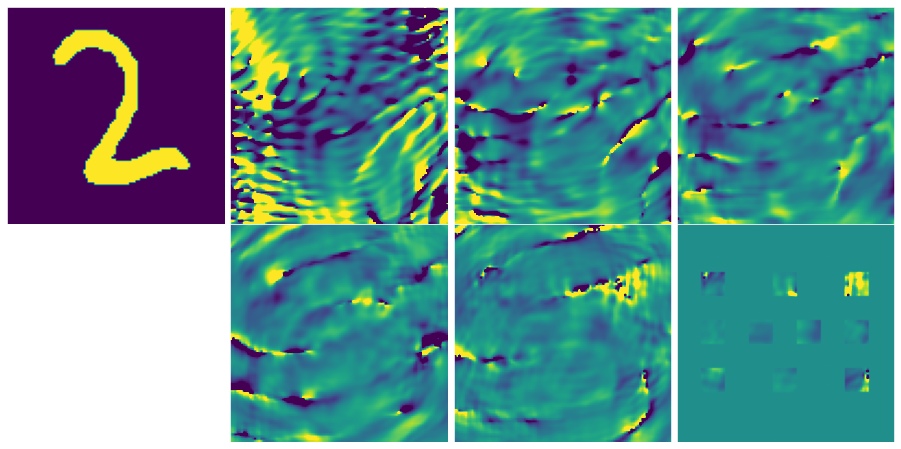

In [26]:
fig.savefig("images/test4.png")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(wspace=0, hspace=0)
for _ax in axes:
    for ax in _ax:
        ax.grid(False)
        ax.set_xticks([], color="none")
        ax.set_yticks([], color="none")
axes[1, 0].remove()
axes[0, 0].imshow(pred[0][2, :, :], cmap="viridis")
axes[0, 1].imshow(pred[1][2, :, :], cmap="viridis",vmin=-np.pi/100, vmax=np.pi/100)
axes[0, 2].imshow(pred[2][2, :, :], cmap="viridis",vmin=-2*np.pi/100, vmax=2*np.pi/100)
axes[0, 3].imshow(pred[3][2, :, :], cmap="viridis",vmin=-3*np.pi/100, vmax=3*np.pi/100)
axes[1, 1].imshow(pred[4][2, :, :], cmap="viridis",vmin=-4*np.pi/100, vmax=4*np.pi/100)
axes[1, 2].imshow(pred[5][2, :, :], cmap="viridis",vmin=-5*np.pi/100, vmax=5*np.pi/100)
axes[1, 3].imshow(pred[6][2, :, :], cmap="viridis",vmin=-5*np.pi/100, vmax=5*np.pi/100)

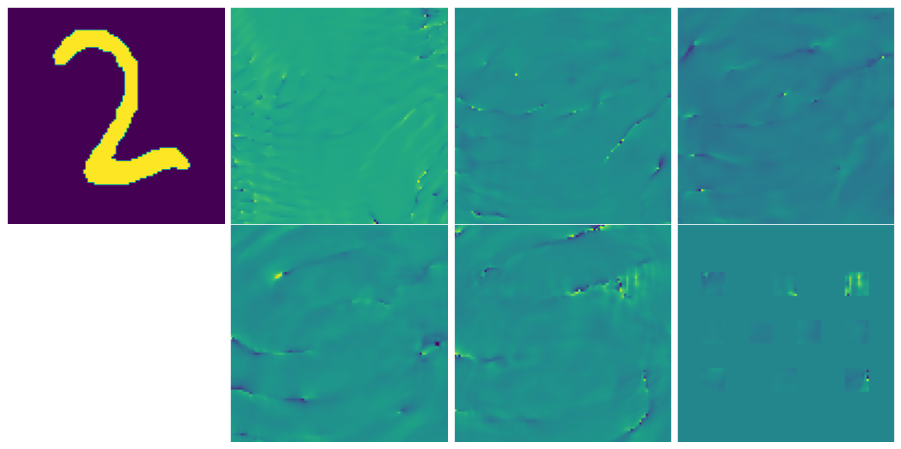

In [25]:
fig, axes = plt.subplots(2,4, figsize=(16, 8))
fig.subplots_adjust(wspace=0, hspace=0)
for _ax in axes:
    for ax in _ax:
        ax.grid(False)
        ax.set_xticks([],color="none")
        ax.set_yticks([],color="none")
axes[1, 0].remove()
axes[0,0].imshow(pred[0][2,:,:], cmap="viridis")
axes[0,1].imshow(pred[1][2,:,:], cmap="viridis")
axes[0,2].imshow(pred[2][2,:,:], cmap="viridis")
axes[0,3].imshow(pred[3][2,:,:], cmap="viridis")
axes[1,1].imshow(pred[4][2,:,:], cmap="viridis")
axes[1,2].imshow(pred[5][2,:,:], cmap="viridis")
axes[1,3].imshow(pred[6][2,:,:], cmap="viridis")

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_82767/310166041.py:3: RuntimeWarning: divide by zero encountered in log
  delta_alpha = -(np.log(1+eta)-np.log(1-eta))
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_82767/310166041.py:7: RuntimeWarning: invalid value encountered in true_divide
  r = (Er-El)/(Er+El)


(-1.0, 1.0)

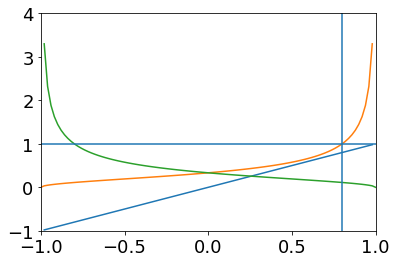

In [15]:
eta_max = 0.8
eta = np.linspace(-1, 1, 100)
delta_alpha = -(np.log(1+eta)-np.log(1-eta))
alpha = np.abs((np.log(1+eta_max)-np.log(1-eta_max)))
Er = np.exp(-(alpha + delta_alpha)/2)
El = np.exp(-(alpha - delta_alpha)/2)
r = (Er-El)/(Er+El)
plt.plot(eta, r)
plt.plot(eta,Er)
plt.plot(eta,El)
plt.vlines(eta_max,-1, 4)
plt.hlines(1, -1, 1)
plt.ylim(-1, 4)
plt.xlim(-1, 1)

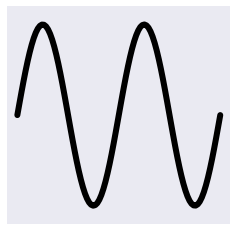

In [97]:
fig,ax = plt.subplots(figsize=(4,4))
r = np.linspace(0, 4*np.pi, 100)
y = np.sin(r)
ax.plot(r, y, color="black", lw=6)
ax.set_xticks([],[])
ax.set_yticks([],[])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)
#ax.set_aspect("equal")
ax.set_ylim(-1.2, 1.2)
fig.savefig("out/util.png", transparent=True)